In [266]:
import matplotlib.pyplot as plt
from custom_scalar_formatter2 import CustomScalarFormatter2
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import os

In [267]:
def get_filenames(results_dir, precond = None):
    if precond is None:
        return os.listdir(results_dir), None
    else:
        names = []
        precond_list = []
        for type in precond:
            precond_names = os.listdir(os.path.join(results_dir, type))
            names.extend(precond_names)
            precond_list.extend(len(precond_names) * [type])
        return names, precond_list

In [268]:
# Gets the reults for a given dataset + optimizer combination
def load_results(dataset, opt, precond = None):
    results = {}
    results_dir = os.path.join('../showcase_results', dataset, opt)
    filenames, precond_list = get_filenames(results_dir, precond) # If preconditioner list is given, get filenames for the preconditioners in that order

    if opt in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
        for filename in filenames:
            if filename.endswith('.csv'):
                    if (filename.startswith('lr') or filename.startswith('L')):
                        start = filename.find('_') + len('_')
                        end = filename.find('_seed_')
                        hyperparam = filename[start:end] # Get lr or L; we assume the hyperparameter only appears once across all files in the folder
                        df = pd.read_csv(os.path.join(results_dir, filename))
                        results[hyperparam] = df
                    elif filename.startswith('auto'):
                        df = pd.read_csv(os.path.join(results_dir, filename))
                        results['auto'] = df
    elif opt in ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']:
        for filename, preconditioner in zip(filenames, precond_list):
            if filename.endswith('.csv'):
                df = pd.read_csv(os.path.join(results_dir, preconditioner, filename))
                results[preconditioner] = df # We assume the preconditioner only appears once across all files in the folder

    return results

In [269]:
def get_best_peak_run(opt_results, opt_name, metric):
    best_run = None
    best_hyperparam = None

    for key in opt_results.keys():
        if best_run is None:
            best_run = opt_results[key]
            if opt_name in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
                best_hyperparam = key
        else:
            if 'loss' in metric:
                if np.min(opt_results[key][metric]) < np.min(best_run[metric]):
                    best_run = opt_results[key]
                    if opt_name in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
                        best_hyperparam = key
            elif 'acc' in metric:
                if np.max(opt_results[key][metric]) > np.max(best_run[metric]):
                    best_run = opt_results[key]
                    if opt_name in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
                        best_hyperparam = key
    
    return best_run, best_hyperparam

In [270]:
def get_results(dataset, opts, preconditioners, auto_only):
    results = {}

    opts_new = []
    for opt in opts:
        if opt in ['svrg', 'saga', 'lkatyusha', 'slbfgs']:
            opt_results = load_results(dataset, opt)

            if auto_only: # Remove everything but auto from opt_results
                if 'auto' in opt_results.keys():
                    results[opt] = {key: opt_results[key] for key in opt_results.keys() if key == 'auto'}
                    opts_new.append(opt)
            else: # Remove auto from opt_results
                results[opt] = {key: opt_results[key] for key in opt_results.keys() if key != 'auto'}
                opts_new.append(opt)
        elif opt in ['sketchysvrg', 'sketchysaga', 'sketchykatyusha']:
            for precond in preconditioners:
                results[(opt, precond)] = load_results(dataset, opt, [precond])
                opts_new.append((opt, precond))

    return results, opts_new

In [271]:
def get_opt_precond_name(opt):
    if isinstance(opt, tuple):
        opt_name = opt[0]
        precond_name = opt[1]
    else:
        opt_name = opt
        precond_name = None
    
    return opt_name, precond_name

In [272]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name.startswith('sketchy'):
        linestyle = 'solid'
        marker = markers[precond_name]
        color = colors[opt_name]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'dashed'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]

    return linestyle, marker, color, label

In [273]:
def get_legend(results_keys, markers, colors, opt_plot_names, precond_plot_names):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in list(results_keys):
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
        legend_elements.append(Line2D([0], [0], color=color, label=label, linestyle = linestyle, marker = marker))
    return legend_elements

In [274]:
def plot_opt_curve(results, opt, key, best_hyperparam, metric, color,
                    linestyle, marker, axes, zorder):
    # If we are plotting something other than sketchysgd that does not correspond to the best hyperparameter, make it invisible
    if opt in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha'] and key != best_hyperparam:
        alpha = 0
    else:
        alpha = 1

    x = np.cumsum(results[opt][key]['times'])/60 # Convert to minutes

    if 'loss' in metric['name']:
        axes.semilogy(x, results[opt][key][metric['name']],
                        color, alpha = alpha, linestyle = linestyle, marker = marker,
                          markevery = 10, zorder = zorder)
    else:
        if metric['option'] == 'inv':
            axes.plot(x, 100 - results[opt][key][metric['name']],
                        color, alpha = alpha, linestyle = linestyle, marker = marker,
                        markevery = 10, zorder = zorder)
        else:
            axes.plot(x, results[opt][key][metric['name']],
                        color, alpha = alpha, linestyle = linestyle, marker = marker,
                        markevery = 10, zorder = zorder)

In [275]:
def format_plot(dataset, ylims, xlabel, metric, axes):
    axes.set_title(dataset, fontsize=14)
    axes.set_ylim(ylims)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.tick_params(axis='both', which='minor', labelsize=10)
    axes.set_xlabel(xlabel, fontsize=14)
    axes.set_ylabel(metric['label'], fontsize=14)

    if 'loss' in metric['name']:
        y_lower_bound, y_upper_bound = axes.get_ylim()
        axes.set_yticks([y_lower_bound, y_upper_bound])

        formatter = CustomScalarFormatter2(useMathText=True, useOffset=False)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))
        axes.yaxis.set_major_formatter(formatter)

        minor_ticks = np.linspace(y_lower_bound, y_upper_bound, num=10)
        minor_ticks = minor_ticks[1:-1]
        axes.set_yticks(minor_ticks, minor=True)
        # axes.yaxis.set_minor_formatter(formatter)
        axes.yaxis.set_minor_formatter(NullFormatter())

In [276]:
def save(directory, fig_name, fig):
    plt.figure(fig)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(os.path.join(directory, fig_name), bbox_inches='tight')

In [277]:
def plot_results(dataset, opts, preconditioners, metric, ylims, colors, markers, opt_plot_names, precond_plot_names, auto_only = False):
    results, opts_new = get_results(dataset, opts, preconditioners, auto_only)

    zorder = lambda opt: 1 if isinstance(opt, tuple) else 2

    plt.figure()
    axes = plt.gca()
    legend_elements = get_legend(results.keys(), markers, colors, opt_plot_names, precond_plot_names)
    for opt in opts_new:
        _, best_hyperparam = get_best_peak_run(results[opt], opt, metric['name'])
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)

        for hyperparam in results[opt].keys():
            plot_opt_curve(results, opt, hyperparam, best_hyperparam, metric, color, linestyle, marker, axes, zorder(opt))
    
    format_plot(dataset, ylims, 'Wall-clock time (min.)', metric, axes)

    axes.legend(handles = legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [278]:
def plot_results_multi_datasets(datasets, opts, preconditioners, metric, ylims_list, colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = False):
    n_datasets = len(datasets)
    fig, axes = plt.subplots(nrows = 1, ncols = n_datasets, figsize = (n_datasets*4, 3))

    zorder = lambda opt: 1 if isinstance(opt, tuple) else 2

    for i, dataset in enumerate(datasets):

        results, opts_new = get_results(dataset, opts, preconditioners, auto_only)
        if i == 0: # Only need to get legend elements once
            legend_elements = get_legend(results.keys(), markers, colors, opt_plot_names, precond_plot_names)
        for opt in opts_new:
            _, best_hyperparam = get_best_peak_run(results[opt], opt, metric['name'])
            opt_name, precond_name = get_opt_precond_name(opt)
            linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)

            for hyperparam in results[opt].keys():
                plot_opt_curve(results, opt, hyperparam, best_hyperparam, metric, color, linestyle, marker, axes[i], zorder(opt))
        
        format_plot(dataset, ylims_list[i], 'Wall-clock time (min.)', metric, axes[i])

    for ax in axes.flat:
        ax.set_ylabel('') # Turn off y-labels for subplots

    fig.text(0, 0.5, metric['label'], va='center', rotation='vertical', fontsize=14)

    fig.tight_layout(pad=2.0)
    
    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, fontsize=14)

    metric_name = metric['name'] + f"_{metric['option']}" if 'option' in metric.keys() else metric['name']
    fig_name = f"combined_{metric_name}_{'auto' if auto_only else 'tuned'}.pdf"
    save_dir = os.path.join(save_dir) 
    save(save_dir, fig_name, fig)

In [279]:
def plot_results_multi_datasets_metrics(datasets, opts, preconditioners, metrics, ylims_list, colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = False):
    n_datasets = len(datasets)
    fig, axes = plt.subplots(nrows = 1, ncols = n_datasets, figsize = (n_datasets*4, 3))

    zorder = lambda opt: 1 if isinstance(opt, tuple) else 2

    for i, (dataset, metric) in enumerate(zip(datasets, metrics)):

        results, opts_new = get_results(dataset, opts, preconditioners, auto_only)
        if i == 0: # Only need to get legend elements once
            legend_elements = get_legend(results.keys(), markers, colors, opt_plot_names, precond_plot_names)
        for opt in opts_new:
            _, best_hyperparam = get_best_peak_run(results[opt], opt, metric['name'])
            opt_name, precond_name = get_opt_precond_name(opt)
            linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)

            for hyperparam in results[opt].keys():
                plot_opt_curve(results, opt, hyperparam, best_hyperparam, metric, color, linestyle, marker, axes[i], zorder(opt))
        
        format_plot(dataset, ylims_list[i], 'Wall-clock time (min.)', metric, axes[i])

    # for ax in axes.flat:
        # ax.set_ylabel('') # Turn off y-labels for subplots

    # fig.text(0, 0.5, metric['label'], va='center', rotation='vertical', fontsize=14)

    fig.tight_layout(pad=2.0)
    
    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, fontsize=14)

    metrics_concat = '_'.join([metric['name'] + f"_{metric['option']}" if 'option' in metric.keys() else metric['name'] for metric in metrics])
    fig_name = f"combined_{metrics_concat}_{'auto' if auto_only else 'tuned'}.pdf"
    save_dir = os.path.join(save_dir) 
    save(save_dir, fig_name, fig)

In [280]:
def plot_results_tuned_untuned(dataset, opts, preconditioners, metric, ylims, colors, markers, opt_plot_names, precond_plot_names, save_dir):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (2*4, 3))
    auto_only_list = [True, False]

    zorder = lambda opt: 1 if isinstance(opt, tuple) else 2

    for i, auto_only in enumerate(auto_only_list):
        results, opts_new = get_results(dataset, opts, preconditioners, auto_only)
        if not auto_only: # Only need to get legend elements once
            legend_elements = get_legend(results.keys(), markers, colors, opt_plot_names, precond_plot_names)
            for elem in legend_elements:
                if elem.get_label() == 'SketchyKatyusha (SSN)':
                    elem.set_label('SketchyKatyusha (Ours)')
        for opt in opts_new:
            _, best_hyperparam = get_best_peak_run(results[opt], opt, metric['name'])
            opt_name, precond_name = get_opt_precond_name(opt)
            linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)

            for hyperparam in results[opt].keys():
                plot_opt_curve(results, opt, hyperparam, best_hyperparam, metric, color, linestyle, marker, axes[i], zorder(opt))
                if opt == ('sketchykatyusha', 'ssn'):
                    metric_at_start = results[opt][hyperparam][metric['name']][0]
                    x = np.cumsum(results[opt][hyperparam]['times'])/60
                    if 'loss' in metric['name']:
                        axes[i].semilogy(x, metric_at_start * np.ones(x.shape), color='k', linestyle='dotted', linewidth=1.5)
                    else:
                        if metric['option'] == 'inv':
                            axes[i].plot(x, 100 - metric_at_start * np.ones(x.shape), color='k', linestyle='dotted', linewidth=1.5)
                        else:
                            axes[i].plot(x, metric_at_start * np.ones(x.shape), color='k', linestyle='dotted', linewidth=1.5)
                    # axes[i].axhline(y=metric_at_start, color='k', linestyle='dotted', linewidth=1)

        
        format_plot(dataset, ylims, 'Wall-clock time (min.)', metric, axes[i])

    for ax in axes.flat:
        ax.set_ylabel('') # Turn off y-labels for subplots

    fig.text(0, 0.5, metric['label'], va='center', rotation='vertical', fontsize=14)

    fig.tight_layout(pad=2.0)
    
    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=2, fontsize=14)

    metric_name = metric['name'] + f"_{metric['option']}" if 'option' in metric.keys() else metric['name']
    fig_name = f"{dataset}_{metric_name}_combined_auto.pdf"
    save_dir = os.path.join(save_dir) 
    save(save_dir, fig_name, fig)

In [281]:
colors = {
    'svrg': 'tab:blue', 
    'saga': 'tab:orange', 
    'lkatyusha': 'tab:pink',
    'slbfgs': 'tab:brown',
    'sketchysvrg': 'tab:blue',
    'sketchysaga': 'tab:orange',
    'sketchykatyusha': 'tab:pink'
}

markers = {
    'diagonal': 'o',
    'nystrom': '^',
    'sassn': 's',
    'lessn': 'd',
    'ssn': '*'
}

opt_plot_names = {
    'svrg': 'SVRG',
    'saga': 'SAGA',
    'lkatyusha': 'L-Katyusha',
    'slbfgs': 'SLBFGS',
    'sketchysvrg': 'SketchySVRG',
    'sketchysaga': 'SketchySAGA',
    'sketchykatyusha': 'SketchyKatyusha',
}

precond_plot_names = {
    'diagonal': 'DiagSSN',
    'nystrom': 'NySSN',
    'sassn': 'SASSN-C',
    'lessn': 'SASSN-R',
    'ssn': 'SSN',
}

In [282]:
opts = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchysvrg', 'sketchysaga', 'sketchykatyusha']
# preconditioners = ['diagonal', 'nystrom', 'ssn', 'sassn', 'lessn']
preconditioners = ['nystrom', 'ssn']
metrics = [{'name': 'test_acc', 'label': 'Test Accuracy (\%)', 'option': 'standard'},
           {'name': 'train_acc', 'label': 'Training Accuracy (\%)', 'option': 'standard'},
           {'name': 'test_loss', 'label': 'Test Loss'},
           {'name': 'train_loss', 'label': 'Training Loss'},
           {'name': 'test_acc', 'label': 'Test Classification Error (\%)', 'option': 'inv'},
           {'name': 'train_acc', 'label': 'Training Classification Error (\%)', 'option': 'inv'},]

save_dir = './showcase'

In [283]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

## Intro plots

### url

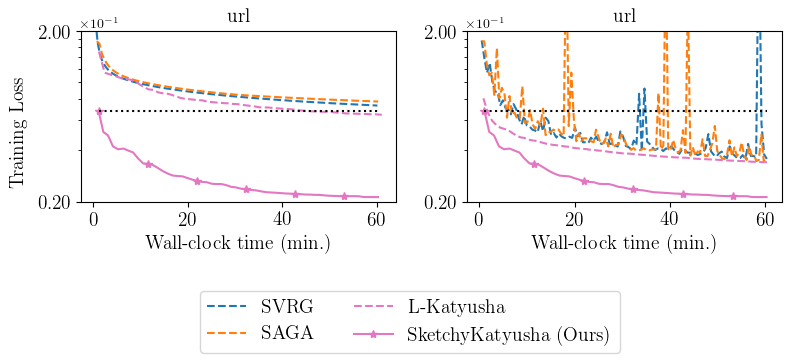

In [284]:
opts_trunc = ['svrg', 'saga', 'lkatyusha', 'sketchykatyusha']
preconditioners_trunc = ['ssn']
plot_results_tuned_untuned('url', opts_trunc, preconditioners_trunc, metrics[3], [2e-2, 2e-1], colors, markers, opt_plot_names, precond_plot_names, save_dir)

In [285]:
# plot_results_tuned_untuned('url', opts_trunc, preconditioners_trunc, metrics[0], [96, 100], colors, markers, opt_plot_names, precond_plot_names, save_dir)

In [286]:
# plot_results_tuned_untuned('url', opts_trunc, preconditioners_trunc, metrics[4], [0, 4], colors, markers, opt_plot_names, precond_plot_names, save_dir)

## All tuned

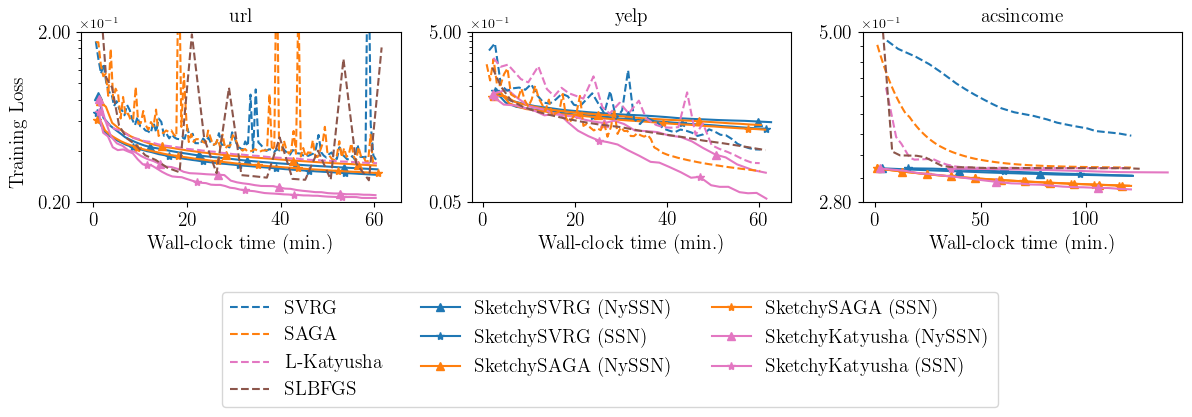

In [287]:
plot_results_multi_datasets(['url', 'yelp', 'acsincome'], opts, preconditioners, metrics[3], [[2e-2, 2e-1], [5e-3, 5e-1], [2.8e-1, 5e-1]], colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = False)

In [288]:
# plot_results_multi_datasets_metrics(['url', 'yelp', 'acsincome'], opts, preconditioners, [metrics[0], metrics[0], metrics[2]], [[96, 100], [95, 98], [2.8e-1, 5e-1]], colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = False)

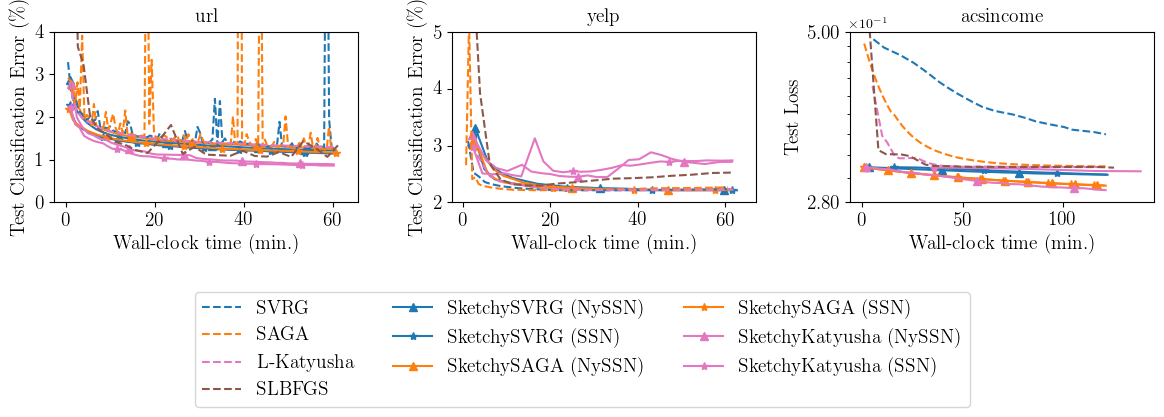

In [289]:
plot_results_multi_datasets_metrics(['url', 'yelp', 'acsincome'], opts, preconditioners, [metrics[4], metrics[4], metrics[2]], [[0, 4], [2, 5], [2.8e-1, 5e-1]], colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = False)

### url

In [290]:
# plot_results('url', opts, preconditioners, metrics[3], [2e-2, 2e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = False)

### yelp

In [291]:
# plot_results('yelp', opts, preconditioners, metrics[3], [5e-3, 5e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = False)                

In [292]:
# opts_trunc = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchykatyusha']
# preconditioners_trunc = ['ssn']
# plot_results('yelp', opts_trunc, preconditioners_trunc, metrics[3], [5e-3, 5e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = False)
# plt.savefig('yelp_time_intro_tuned.pdf', bbox_inches='tight')

### acsincome

In [293]:
# plot_results('acsincome', opts, preconditioners, metrics[3], [2.8e-1, 5e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = False)

## All auto

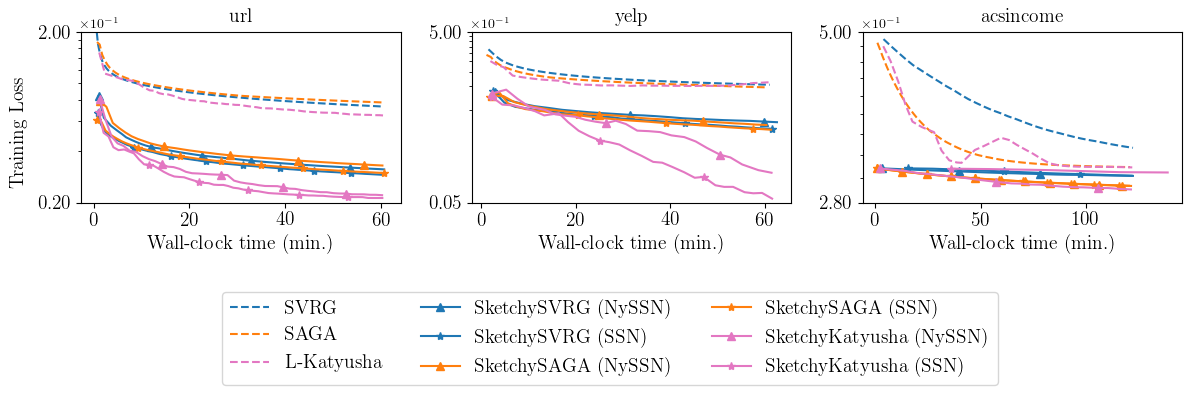

In [294]:
plot_results_multi_datasets(['url', 'yelp', 'acsincome'], opts, preconditioners, metrics[3], [[2e-2, 2e-1], [5e-3, 5e-1], [2.8e-1, 5e-1]], colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = True)

In [295]:
# plot_results_multi_datasets_metrics(['url', 'yelp', 'acsincome'], opts, preconditioners, [metrics[0], metrics[0], metrics[2]], [[96, 100], [95, 98], [2.8e-1, 5e-1]], colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = True)

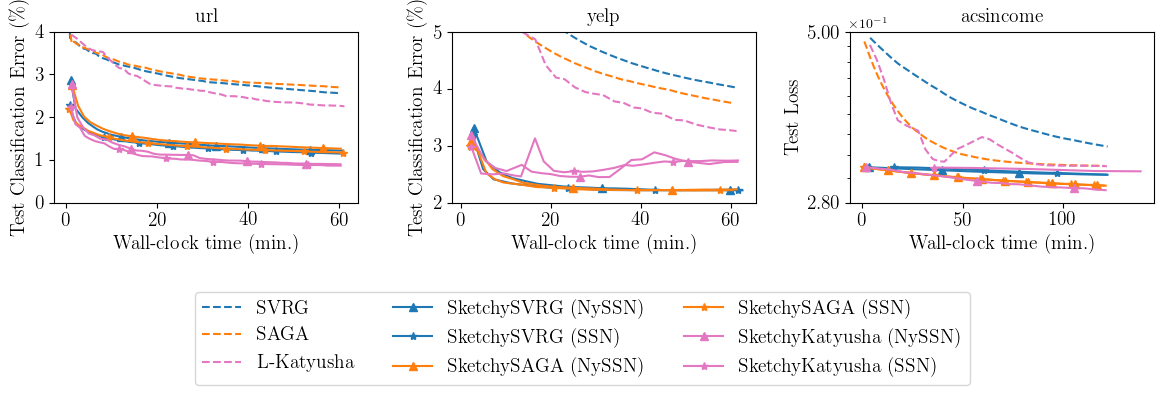

In [296]:
plot_results_multi_datasets_metrics(['url', 'yelp', 'acsincome'], opts, preconditioners, [metrics[4], metrics[4], metrics[2]], [[0, 4], [2, 5], [2.8e-1, 5e-1]], colors, markers, opt_plot_names, precond_plot_names, save_dir, auto_only = True)

### url

In [297]:
# plot_results('url', opts, preconditioners, metrics[3], [2e-2, 2e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = True)

### yelp

In [298]:
# plot_results('yelp', opts, preconditioners, metrics[3], [5e-3, 5e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = True)   

In [299]:
# opts_trunc = ['svrg', 'saga', 'lkatyusha', 'slbfgs', 'sketchykatyusha']
# preconditioners_trunc = ['ssn']
# plot_results('yelp', opts_trunc, preconditioners_trunc, metrics[3], [5e-3, 5e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = True)
# plt.savefig('yelp_time_intro_auto.pdf', bbox_inches='tight')

### acsincome

In [300]:
# plot_results('acsincome', opts, preconditioners, metrics[3], [2.8e-1, 5e-1], colors, markers, opt_plot_names, precond_plot_names, auto_only = True)